## 1. Import Standard Libraries

In [1]:
from IPython import display

import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional  as F

## 2. Create and inspect the data

In [4]:
# create data

# Number per cluster
nPerClust = 300
blur = 1

A = [ 1, 1 ]
B = [ 5, 1 ]
C = [ 4, 4 ]

# generate data
a = [ A[0]+np.random.randn(nPerClust)*blur , A[1]+np.random.randn(nPerClust)*blur ]
b = [ B[0]+np.random.randn(nPerClust)*blur , B[1]+np.random.randn(nPerClust)*blur ]
c = [ C[0]+np.random.randn(nPerClust)*blur , C[1]+np.random.randn(nPerClust)*blur ]

# true labels
labels_np = np.hstack((  np.zeros((nPerClust)),
                         np.ones( (nPerClust)),
                       1+np.ones( (nPerClust))  ))

# concatanate into a matrix
data_np = np.hstack((a,b,c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()

# note: "long" format for CCE
labels = torch.tensor(labels_np).long() 


### Data  Visualization

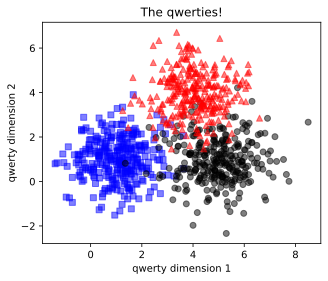

In [5]:
fig = plt.figure(figsize=(5,4), dpi = 145)

plt.plot(data[np.where(labels==0)[0],0],data[np.where(labels==0)[0],1],'bs',alpha=.5)
plt.plot(data[np.where(labels==1)[0],0],data[np.where(labels==1)[0],1],'ko',alpha=.5)
plt.plot(data[np.where(labels==2)[0],0],data[np.where(labels==2)[0],1],'r^',alpha=.5)

plt.title('The qwerties!')

plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')

plt.show()

## 3. Convert the Data into Tensor Dataset

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader,TensorDataset

In [7]:
[3*nPerClust-400,200,200]

[500, 200, 200]

In [8]:
# specify sizes of the partitions
# order is train,devset,test
partitions = [3*nPerClust-400,200,200]

# split the data
train_data,devtest_data, train_labels,devtest_labels = train_test_split(data, labels, train_size=partitions[0])

# now split the devtest data
dev_data,test_data, dev_labels,test_labels = train_test_split(devtest_data, devtest_labels, train_size=partitions[1])


# print out the sizes
print('   Total data size: ' + str(data.shape) + '\n')
print('Training data size: ' + str(train_data.shape))
print('  Devset data size: ' + str(dev_data.shape))
print('    Test data size: ' + str(test_data.shape))

   Total data size: torch.Size([900, 2])

Training data size: torch.Size([500, 2])
  Devset data size: torch.Size([200, 2])
    Test data size: torch.Size([200, 2])


In [9]:
# convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data,train_labels)
dev_data   = TensorDataset(dev_data,dev_labels)
test_data  = TensorDataset(test_data,test_labels)

# finally, translate into dataloader objects
batchsize    = 30

train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
dev_loader   = DataLoader(dev_data,batch_size=dev_data.tensors[0].shape[0])
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [10]:
train_loader, dev_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x20a02797c40>,
 <torch.utils.data.dataloader.DataLoader at 0x20a02797ca0>)

## 4. Create and validate the model

In [11]:
# create a class for the model
def createTheQwertyNet(LR):

    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            ### Input layer
            self.input = nn.Linear(2,8)

            ### Hidden layer
            self.fc1 = nn.Linear(8,8)

            ### Output layer
            self.output = nn.Linear(8,3)

        # forward pass
        def forward(self,x):
            x = F.relu( self.input(x) )
            x = F.relu( self.fc1(x) )
            
            return self.output(x)
  
    # create the model instance
    ANN_model = qwertyNet()
  
    # loss function
    lossfunc = nn.CrossEntropyLoss()

    # optimizer
    optimizer = torch.optim.SGD(ANN_model.parameters(),lr=LR)

    return ANN_model,lossfunc,optimizer


## 5. Model Training

In [12]:
import copy

In [13]:
def function2trainTheModel(Model, lossfunc, optimizer, train_loader, dev_loader, epochs):

    # Initialize a dictionary for the best model
    theBestModel = {'Accuracy':0, 'net':None}

    # initialize losses
    losses   = torch.zeros(epochs)
    trainAcc = []
    devAcc   = []

    # loop over epochs
    for epochi in range(epochs):

        # switch on training mode
        Model.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
        
        for X,y in train_loader:

            # forward pass and loss
            yHat = Model(X)
            loss = lossfunc(yHat,y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
            matchesNumeric = matches.float()             # convert to numbers (0/1)
            accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
            batchAcc.append( accuracyPct )               # add to list of accuracies
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append( np.round(np.mean(batchAcc),2 ))

        # Get average losses across the batches
        losses[epochi] = np.round(np.mean(batchLoss),2)

        # test accuracy
        Model.eval()
        X,y = next(iter(dev_loader))  # extract X,y from devset data loader
        with torch.no_grad():         # deactivates autograd
            yHat_dev = Model(X)
      
        # Compare the following really long line of code to the training accuracy lines
        devAcc.append( 100*torch.mean((torch.argmax(yHat_dev,axis=1)==y).float()) )
        

        # Store this model if it's the best so far
        if devAcc[-1]>theBestModel['Accuracy']:

            # new best accuracy
            theBestModel['Accuracy'] = devAcc[-1].item()

            # model's internal state
            theBestModel['net'] = copy.deepcopy( Model.state_dict() )
      
        # End epochs

    # function output
    return trainAcc,devAcc,losses,theBestModel


## 6.  Run the model and plot the results

In [14]:
ANN_model,Lossfunc,Optimizer = createTheQwertyNet(LR = 0.01)

In [15]:
# trainAcc,devAcc,losses,theBestModel
# train_loader, dev_loader, test_loader
# function2trainTheModel(Model, lossfunc, optimizer, train_loader, dev_loader, epochs)

In [16]:
# 10 mins time it took 
TrainAcc,DevAcc,Losses,BestModel = function2trainTheModel(Model=ANN_model , 
                                                          lossfunc=Lossfunc , 
                                                          optimizer=Optimizer,
                                                          train_loader=train_loader , 
                                                          dev_loader=dev_loader, 
                                                          epochs = 200)

## 7. Results Visualization

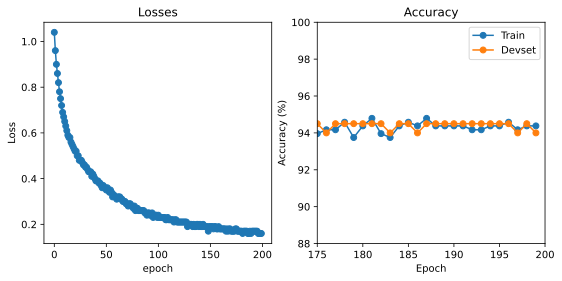

In [17]:
fig,ax = plt.subplots(1,2,figsize=(9,4) ,dpi=145)

ax[0].plot(Losses.detach(),'o-')
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('epoch')
ax[0].set_title('Losses')

ax[1].plot(TrainAcc,'o-',label='Train')
ax[1].plot(DevAcc,'o-',label='Devset')

ax[1].set_ylabel('Accuracy (%)')
ax[1].set_xlabel('Epoch')
ax[1].set_title('Accuracy')

ax[1].set_ylim([88,100])
ax[1].set_xlim([175,200])

ax[1].legend()

plt.show()

In [18]:
BestModel

{'Accuracy': 94.5,
 'net': OrderedDict([('input.weight',
               tensor([[-0.5658,  0.7327],
                       [-0.3128, -0.1852],
                       [ 0.3313,  0.7355],
                       [-0.1242,  0.8787],
                       [ 1.2623, -0.0903],
                       [-0.5625,  0.1263],
                       [ 0.3444,  0.9012],
                       [-0.3258,  0.6274]])),
              ('input.bias',
               tensor([ 0.8538, -0.5753, -0.7120, -0.0054,  0.2743, -0.6303,  0.4733,  0.3004])),
              ('fc1.weight',
               tensor([[-0.1061,  0.2524, -0.1765, -0.3749,  0.8795,  0.2833, -0.1470, -0.2517],
                       [-0.2415,  0.2181,  0.5540,  0.0858,  0.4364,  0.1173, -0.1637, -0.0179],
                       [-0.1919, -0.3221,  0.3372,  0.2631,  0.0886, -0.2439,  0.2486, -0.1704],
                       [-0.5895, -0.2684,  0.0914,  0.3898, -0.1926, -0.0983,  0.5248,  0.2030],
                       [ 0.0550, -0.1671, -0.0896,  

## 8. Testing the best model on Test Dataset

In [19]:
# extract X,y from test dataloader
X,y = next(iter(test_loader)) 

# Below code will not work
# yHat = theBestModel['net'](X)

In [20]:
# Recreate the best-performing model
best_ANN_Model = createTheQwertyNet(LR = 0.01)[0]
best_ANN_Model.load_state_dict(BestModel['net'])

<All keys matched successfully>

In [21]:
# Run the data through 

yHat_best = best_ANN_Model(X)

bestAcc = 100*torch.mean((torch.argmax(yHat_best,axis=1)==y).float())
bestAcc

tensor(89.5000)

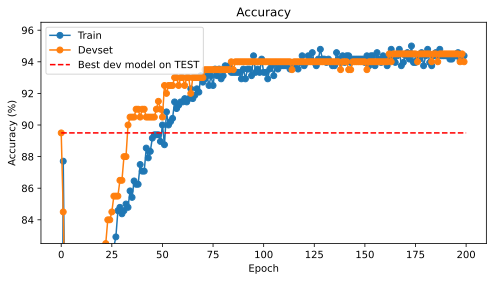

In [23]:
fig = plt.figure(figsize=(8,4), dpi=145)

plt.plot(TrainAcc,'o-',label='Train')
plt.plot(DevAcc,'o-',label='Devset')
plt.plot([0,len(DevAcc)],[bestAcc,bestAcc],'r--',label='Best dev model on TEST')

plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.title('Accuracy')

plt.ylim([bestAcc-7,bestAcc+7])
plt.legend()

plt.show()